<a href="https://colab.research.google.com/github/LaloGarces/Brain-Tumors-Detection-DeepLearning/blob/main/Brain_Tumors_Detection_with_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Brain Tumors Detection with ResNet & ResUNet by [@Lalo Garces](https:/https://www.linkedin.com/in/eduardogarces1//)

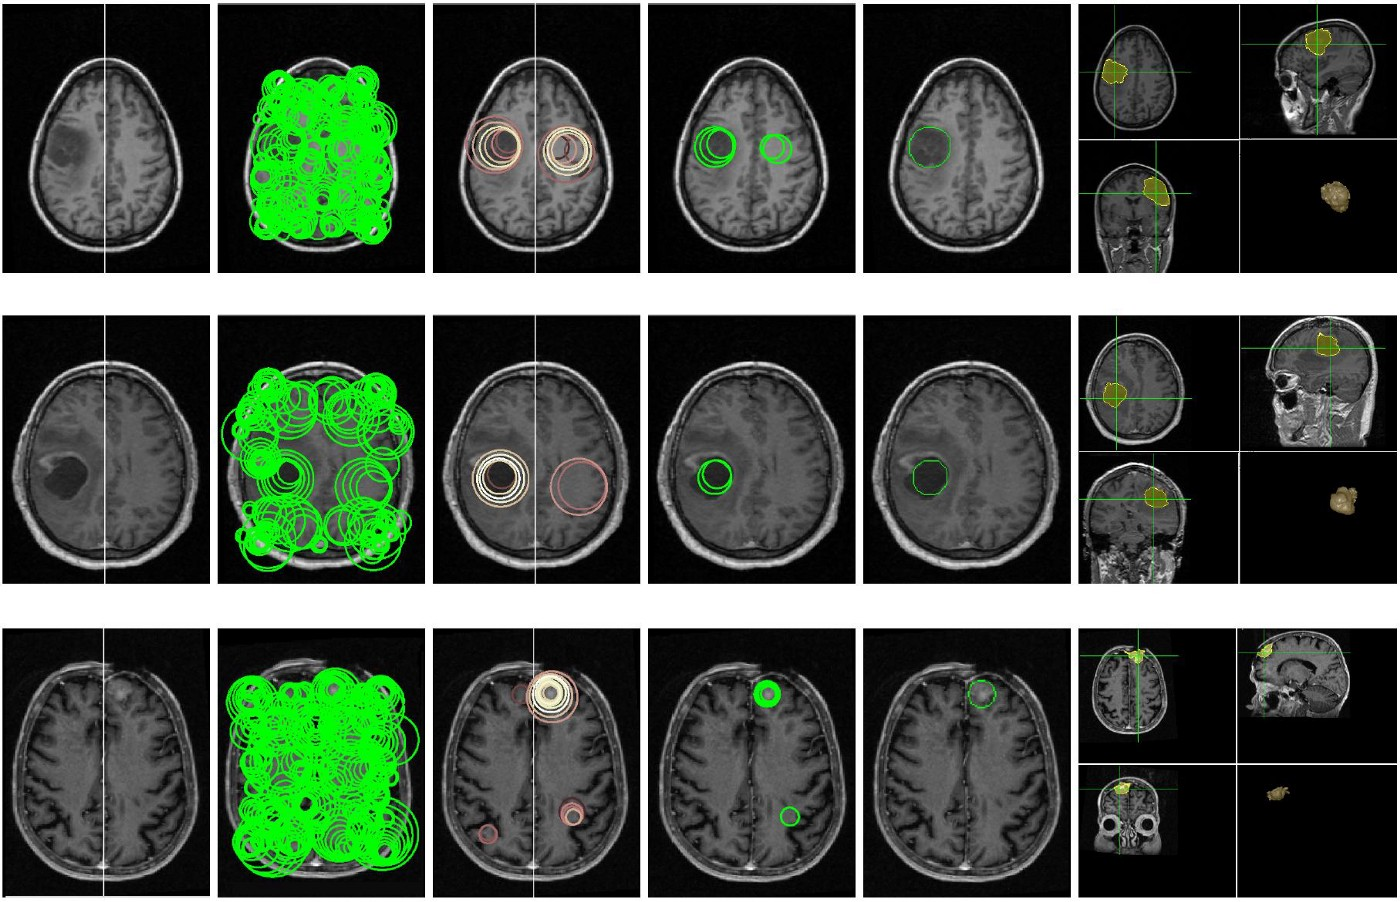

## Important points before start!

* We're going to use an open data source from Kaggle: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation

* ResNet (Residual neural network) is the Deep Learning neural network we're going to use to classify the brain tumors. *ResNet makes it possible to train up to hundreds or even thousands of layers and still achieves compelling performance.*

* The technique to classify the images is going to be with ***image segmentation.***

Like refresher, image segmentation is a method of dividing a digital image into subgroups called image segments, reducing the complexity of the image and enabling further processing or analysis of each image segment.

**Image segmentation is a function that takes image inputs and produces an output.**


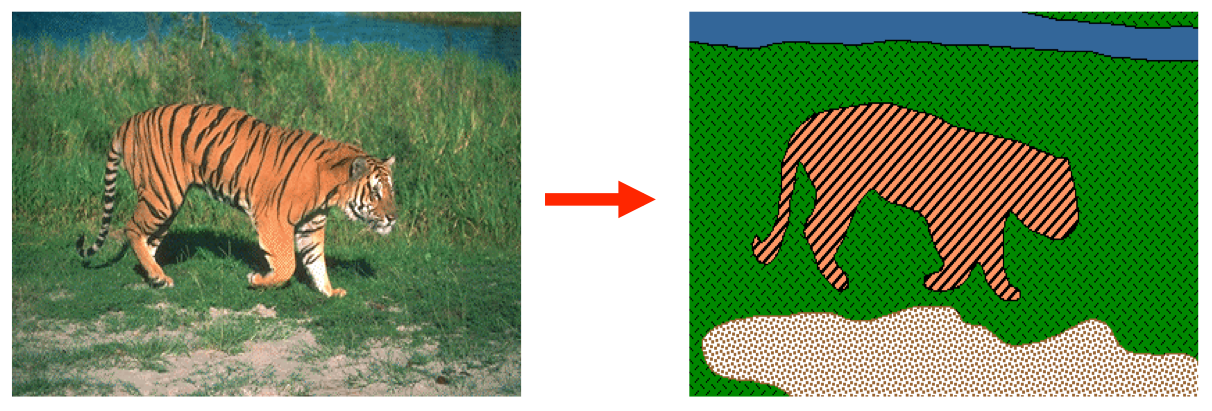

## Why Resnet? 

The more layers we have in our netwrok, not necesary mean better performance:

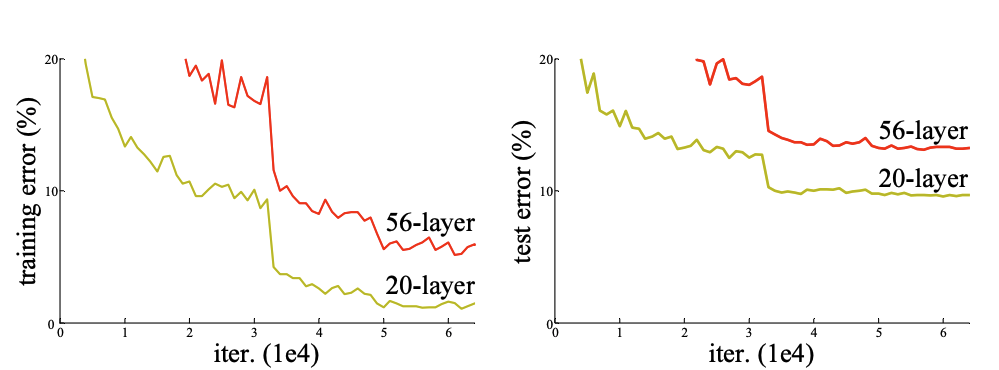

When CNNs grow in a deeper way, occur something called *vanishing gradient*, impacting the performance of the network.

Residual Neural Network helps to "skip connections" between features without impacting the performance of the network.

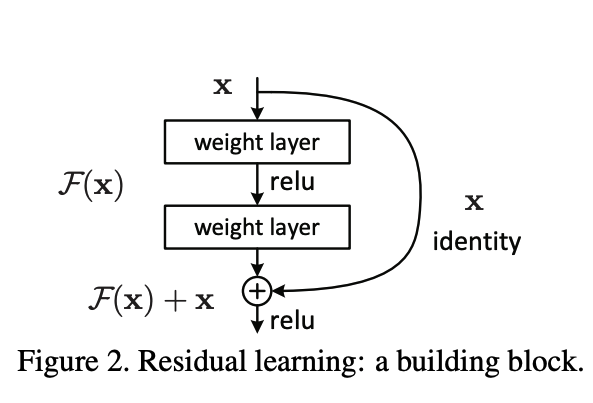

For more info please visit: https://arxiv.org/pdf/1512.03385.pdf

## Transfer Learning

By last, we'e going to use **Transfer Learning** in this classification case. 

Just to remember, transfer learning is using a pre-trained network(pre-trained on a larger dataset) on your data. 

The advantage of using Transfer Learning is

* It gives faster progress.
* Can train using a smaller amount of data.

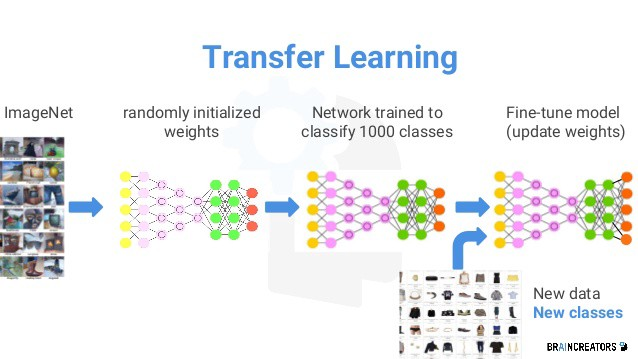

# Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2 #--> Open CV
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [2]:
# Mounting our google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Use your data location
%cd /content/drive/MyDrive/Colab Notebooks/Github/DATA/Brain_MRI


/content/drive/MyDrive/Colab Notebooks/Github/DATA/Brain_MRI


In [4]:
# Loading the data
brain_df = pd.read_csv('data_mask.csv')

In [5]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [6]:
brain_df.head(10)

patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2  TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3  TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4  TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
5  TCGA_CS_5395_19981004  TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif   
6  TCGA_CS_5395_19981004  TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif   
7  TCGA_CS_5395_19981004  TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1.tif   
8  TCGA_CS_5395_19981004  TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1.tif   
9  TCGA_CS_5395_19981004  TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0  
5  TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1_...     0  
6  TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1_...     0  
7  TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1_...     0  
8  TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1_...     0  
9  TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1_...     0

In [7]:
# Path to the brain MRI image
brain_df.mask_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [8]:
# Path to the segmentation mask
brain_df.image_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

When we refer to "mask" bassically are the pixels that represent a color in the images, helping the neural net get an output. For example: 

* Black colored pixels has values of 0

* White colored pixels has values of 255

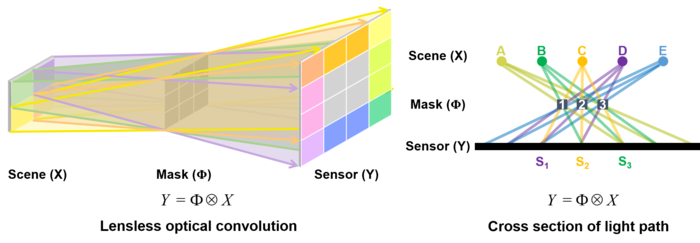

# Data visualization before apply classification model

In [9]:
brain_df

patient_id  \
0     TCGA_CS_5395_19981004   
1     TCGA_CS_5395_19981004   
2     TCGA_CS_5395_19981004   
3     TCGA_CS_5395_19981004   
4     TCGA_CS_5395_19981004   
...                     ...   
3924  TCGA_DU_6401_19831001   
3925  TCGA_DU_6401_19831001   
3926  TCGA_DU_6401_19831001   
3927  TCGA_DU_6401_19831001   
3928  TCGA_DU_6401_19831001   

                                             image_path  \
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
...                                                 ...   
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...   
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...   
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...   
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...   
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...   

                                              mask_path  mask  
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0  
...                                                 ...   ...  
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...     0  
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...     0  
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...     0  
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...     0  
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...     0  

[3929 rows x 4 columns]

In [10]:
#Analyzing the "mask" column, that is our target value. 
brain_df['mask'].value_counts().index

Int64Index([0, 1], dtype='int64')

In [11]:
#Visualizing the mask column just to se the balance of the data. 
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(200,0,200)', marker_line_color = 'rgb(0,300,0)',
                  marker_line_width = 7, opacity = 0.5)
fig.show()

In [12]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [13]:
brain_df.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

▶ To start reading or visualizing the mask and image path, we're going to use open CV (cv2) to convert the data into image. 

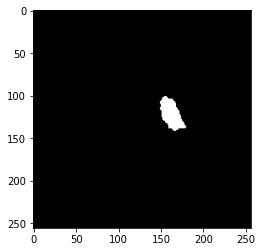

In [14]:
plt.imshow(cv2.imread(brain_df.mask_path[777]))

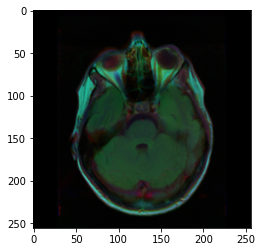

In [15]:
plt.imshow(cv2.imread(brain_df.image_path[777]))

▶ Interesting how making this 2 separate visualizations, we can see the pixel prediction about tumor (mask_path) and the actual image (image_path) to overlap it and let the neural net do the classification

In [16]:
#Analize the maximum value of mask (255 refer to white spaces)
cv2.imread(brain_df.mask_path[777]).max()

255

In [17]:
#Analize the maximum value of mask (0 refer to black spaces)
cv2.imread(brain_df.mask_path[777]).min()

0

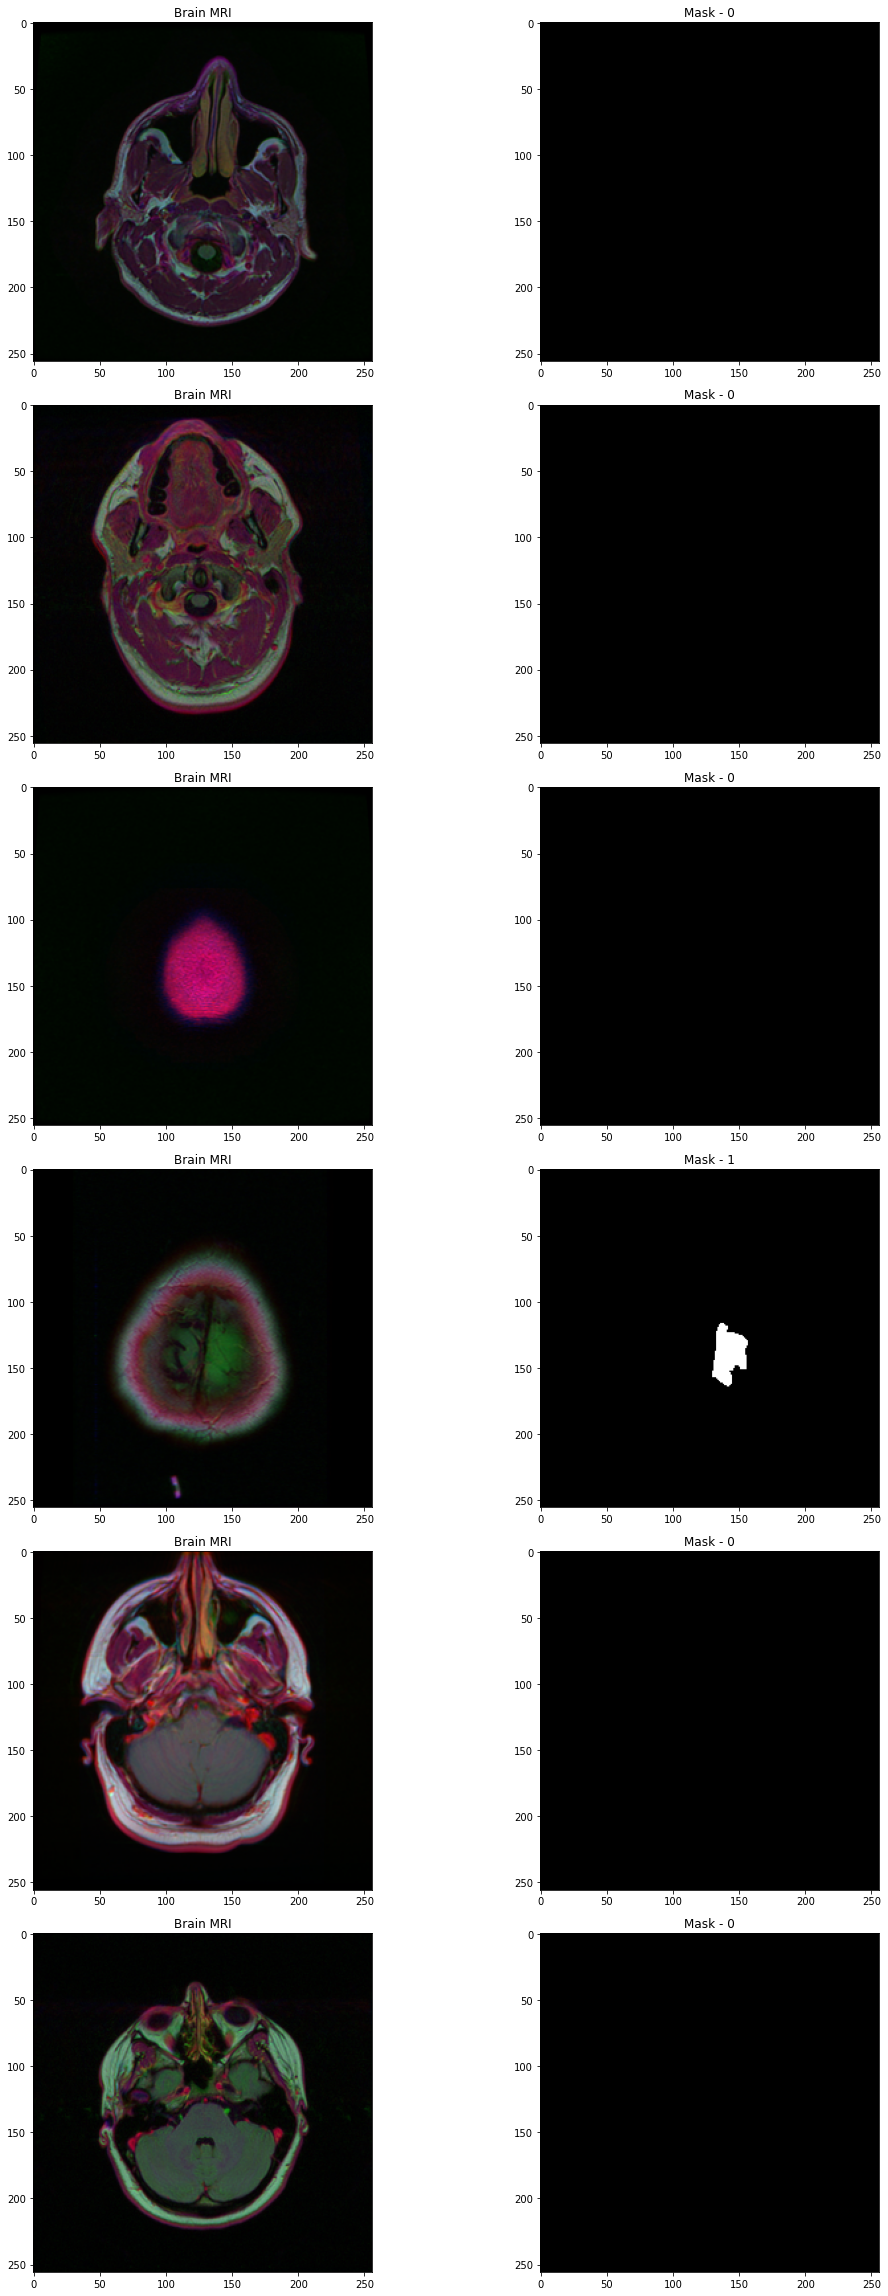

In [18]:
#Visualizing the MRI and the Mask 
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) #--> Selecting a random index
  axs[count][0].title.set_text("Brain MRI") #--> Title of each image
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) #--> Show MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) #--> Plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) #--> Show mask
  count += 1

fig.tight_layout()

Now, we're going to make another visualization but, putting a blue color over the mask classification to see how looks over the original input image.

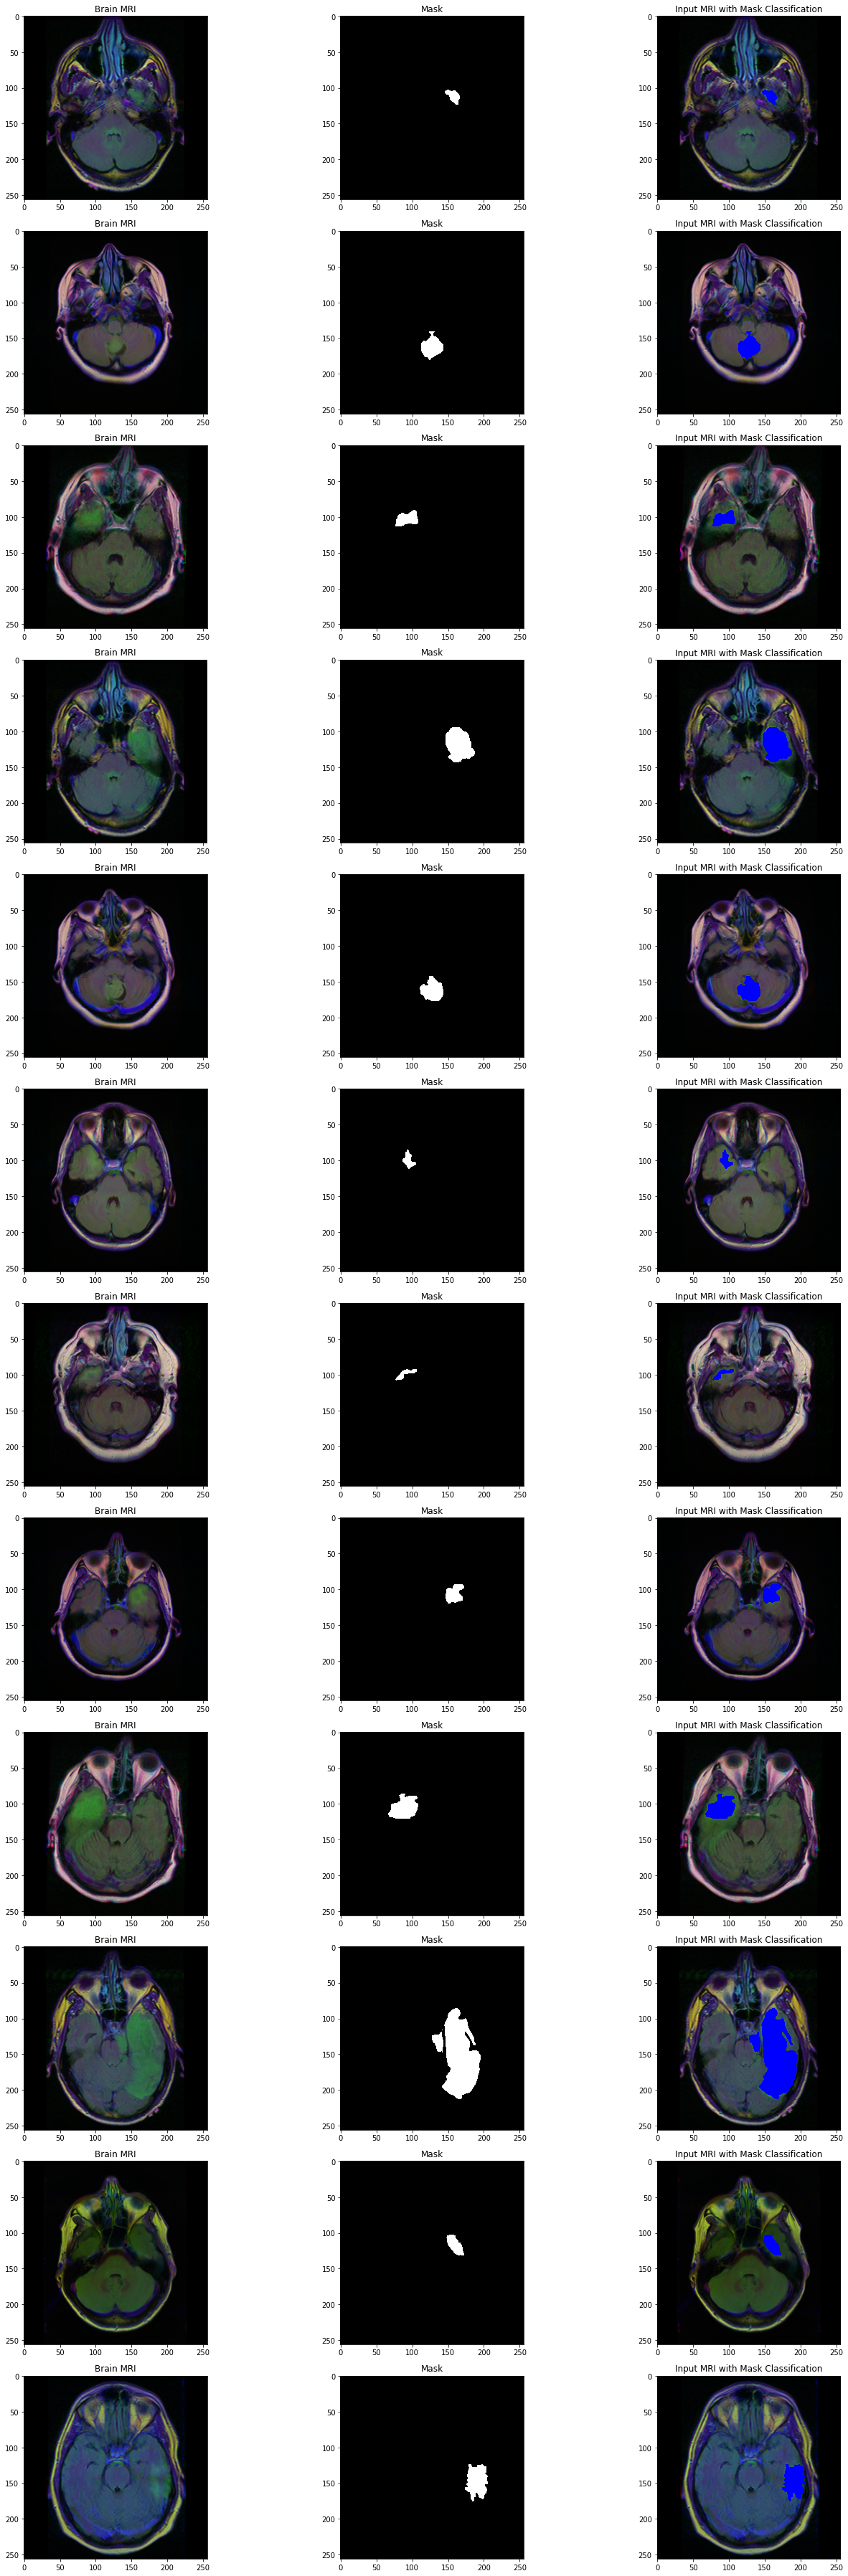

In [19]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] ==1 and count <12:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')

    
    img[mask == 255] = (0, 0, 255)
    axs[count][2].title.set_text('Input MRI with Mask Classification')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()


# Start training our model

In [20]:
# Drop out the patient id column due is not relevant for the model
brain_df_train = brain_df.drop(columns = ['patient_id'])

In [21]:
brain_df_train.shape

(3929, 3)

In [22]:
# TypeError: If class_mode="categorical", y_col="mask" column values must be type string, list or tuple
#To avoid this error, we need to conver the data from "mask" column into string format
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [23]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [24]:
# Start splitting the data into training and test set
#I'm going to use "10%" for testing and "90%" for traning
#I tested the model with & 15% for testing and the results were terrible!
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [25]:
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)


In [26]:
#Train generator
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

#Valid generator
valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create another validator ofr the testing data to be used "after the model is trained"
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))



Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [27]:
# Let's start using our "transfer learning" with the library loaded before: "ResNet50"
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94781440/94765736 [==============================] - 1s 0us/step


In [28]:
basemodel.summary()
#We have input layer
#Convolutional
#poolling
#etc... Really powerfull neural net

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [29]:
# We're going to freeze the trinable layers to do it manually in the next code

for layer in basemodel.layers:
  layers.trainable = False

In [30]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel) #-->Model with 256 neurons with activation "reLu"
headmodel = Dropout(0.2)(headmodel) #--> (Regularization) We're dropping 20% of neurons randomly to avoid dependency between neurons
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [32]:
# Compile model
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [33]:
#Early stopping help us to exit training if validation loss is not decreasing even after certain epochs
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

#Saving the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [34]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 20, epochs = 1, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

141/141 [==============================] - ETA: 0s - loss: 0.7906 - accuracy: 0.6898
Epoch 1: val_loss improved from inf to 9.26585, saving model to classifier-resnet-weights.hdf5
141/141 [==============================] - 889s 6s/step - loss: 0.7906 - accuracy: 0.6898 - val_loss: 9.2659 - val_accuracy: 0.6411


In [35]:
#Save the model architecture to json file for future use
model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

# Test the results of the model

In [36]:
# Load pretrained model ---> After doing a lot of adjustments to the model, I found this pretrained model with hight accuracy values
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# Load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [37]:
#Making the predictions
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 [==============================] - 180s 5s/step


In [38]:
test_predict.shape

(576, 2)

In [39]:
test_predict

array([[9.9998522e-01, 1.4824550e-05],
       [9.9999690e-01, 3.0512010e-06],
       [8.9962473e-12, 1.0000000e+00],
       ...,
       [9.9991131e-01, 8.8633955e-05],
       [2.1022969e-07, 9.9999976e-01],
       [9.9976760e-01, 2.3246311e-04]], dtype=float32)

In [40]:
#Obtain the predicted class from the model (0's and 1) Just to see the output results
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [41]:
predict

array(['0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '1',
       '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '1', '0', '0',
       '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '1',
       '1', '1', '0', '0', '1', '1', '0', '0', '1', '0', '1', '1', '0',
       '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '1', '1',
       '1', '1', '0', '1', '0', '0', '1', '1', '0', '0', '0', '1', '0',
       '1', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0',
       '0', '0', '1', '1', '1', '0', '1', '1', '0', '0', '0', '0', '0',
       '0', '0', '1', '0', '1', '1', '1', '0', '0', '1', '0', '1', '0',
       '1', '1', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0',
       '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0',
       '0', '1', '0', '0', '0', '1', '1', '1', '0', '0', '0', '1', '1',
       '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '1

In [42]:
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [43]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9809027777777778

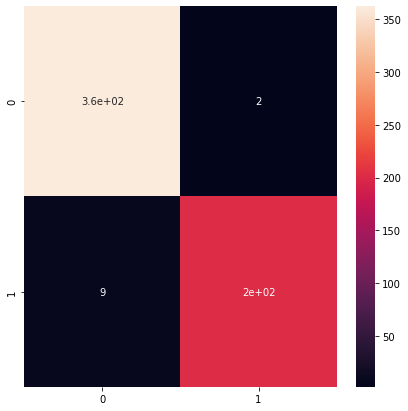

In [44]:
#Plotting confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [45]:
from sklearn.metrics import classification_report
report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       364
           1       0.99      0.96      0.97       212

   micro avg       0.98      0.98      0.98       576
   macro avg       0.98      0.98      0.98       576
weighted avg       0.98      0.98      0.98       576



/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



#Before move forward, a little bit of understanding of ResUNet

Now that we've trained the model and we have predictions outputs, in the next part we like to visualy represent the predictions of the model over the input images, so , with resUNet we can do it. 


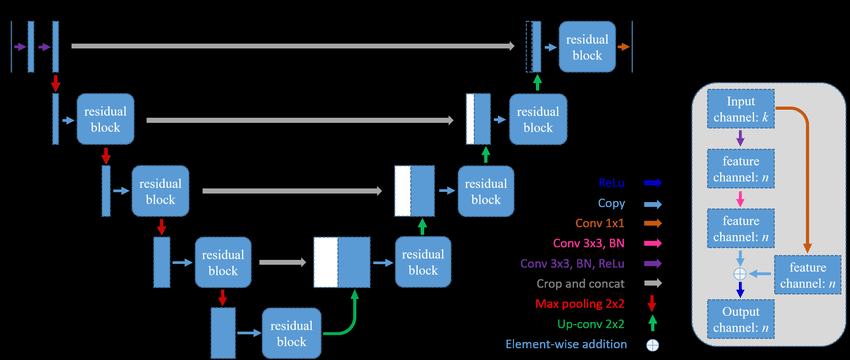

#Start building our ResUNet model

In [46]:
#Get the data that contain only positives results with localized tumors
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [47]:
#Split the data into train and test data
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [48]:
#Create separate list for imageId and classId
#Input MRI Images, outputs the mask result associated to MRI image 

train_ids = list(X_train.image_path) #--> Input
train_mask = list(X_train.mask_path) #--> Output

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [49]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import DataGenerator

#Create image generators
training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [50]:
#Start building the ResNet block
def resblock(X, f):
  

  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [51]:
# Function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [52]:
#Create the blocks of the ResUNet: 

#Res block
#Max Pooling
#Res Block
#Max Pooling ....

input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [53]:
model_seg.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                           

## Loss function

 
We're going to use loss function to train this ResUNet.So,  we have used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py


@article{focal-unet,
  title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation},
  author={Abraham, Nabila and Khan, Naimul Mefraz},
  journal={arXiv preprint arXiv:1810.07842},
  year={2018}
}

In [55]:
# Loading utilities file that contains the code for custom loss function and custom data generator
from utilities import focal_tversky, tversky_loss, tversky

In [56]:
# Compiling the model
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [61]:
#Early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

#Saving the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

# Asses ResUNet model performance

In [64]:
from utilities import focal_tversky, tversky_loss, tversky

with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

#Loading the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [65]:
#Utilities file contains the code for custom loss function and custom data generator
from utilities import prediction

#Doinf prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

In [66]:
#Creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  \
0    TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_29...   
1    TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_13...   
2    TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_19...   
3    TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_37...   
4    TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_1.tif   
..                                                 ...   
585  TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_2.tif   
586  TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_17...   
587  TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_31...   
588  TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_17...   
589  TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_52...   

                                        predicted_mask  has_mask  
0                                              No mask         0  
1                                              No mask         0  
2    [[[[2.9757064e-06], [6.791806e-06], [1.7886888...         1  
3                                              No mask         0  
4                                              No mask         0  
..                                                 ...       ...  
585                                            No mask         0  
586                                            No mask         0  
587  [[[[2.3135038e-07], [6.193948e-07], [1.5865929...         1  
588  [[[[6.6800504e-07], [2.3268294e-06], [4.313124...         1  
589                                            No mask         0  

[590 rows x 3 columns]

In [67]:
#Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  \
0  TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_29...   
1  TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_13...   
2  TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_19...   
3  TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_37...   
4  TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_1.tif   

                                           mask_path mask  \
0  TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_29...    0   
1  TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_13...    0   
2  TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_19...    1   
3  TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_37...    0   
4  TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_1_...    0   

                                      predicted_mask  has_mask  
0                                            No mask         0  
1                                            No mask         0  
2  [[[[2.9757064e-06], [6.791806e-06], [1.7886888...         1  
3                                            No mask         0  
4                                            No mask         0

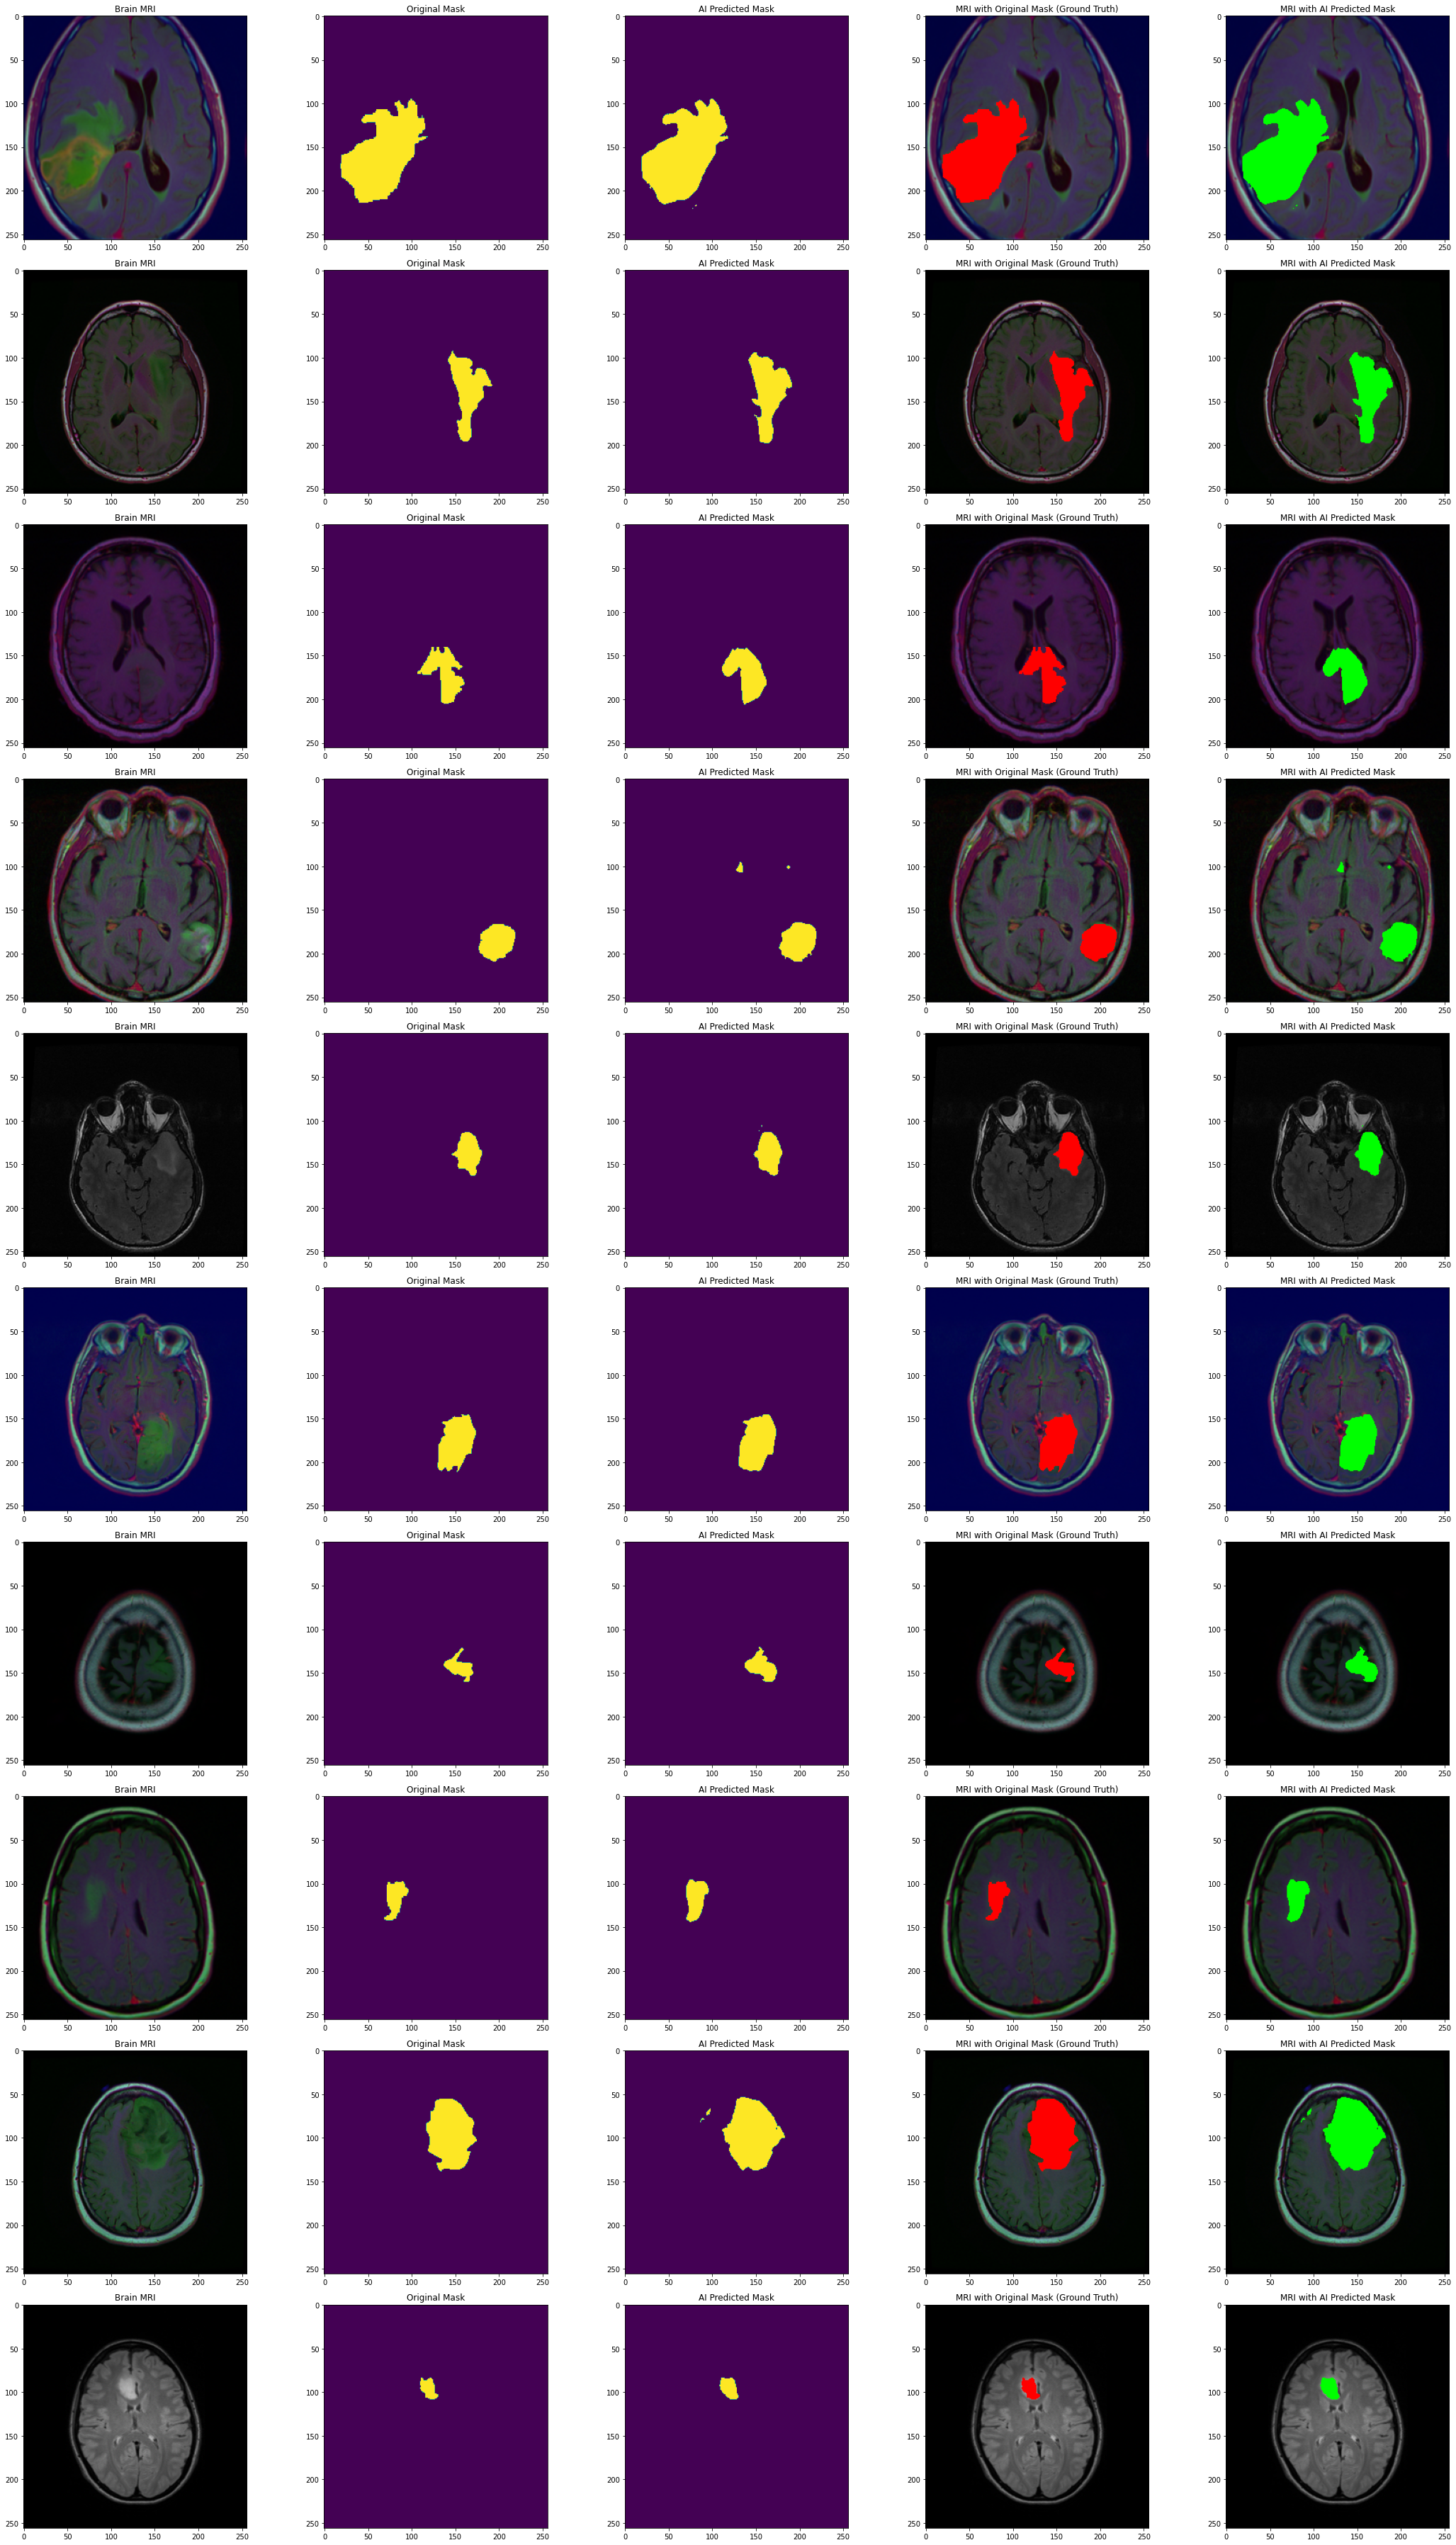

In [68]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()

Aditional credits: Part of the code was used from the lessons taken with **Dr. Ryan Ahmed**.